In [2]:
import os, sys, time, re, warnings
from pathlib import Path

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from scipy.stats import norm
from joblib import Parallel, delayed
from tqdm import tqdm
from numpy.linalg import solve, lstsq, eigvalsh, eigh

# Keep notebook output readable.
warnings.filterwarnings("ignore")
pd.set_option("display.max_columns", 80)
plt.rcParams["figure.dpi"] = 130

# Import the MI utilities (expects ksg_mi_estimator_I inside ksg_tools.py).
try:
    import ksg_tools
    print("Successfully imported ksg_tools.")
except ImportError as e:
    print("ERROR: ksg_tools not found. Ensure ksg_tools.py is importable (add to sys.path).")
    raise

# Data locations (should match the rest of the pipeline outputs).
DATA_ROOT = Path(r"C:\Users\bseis\ABthesis\data")
PROCESSED = DATA_ROOT / "processed"
ANALYSIS  = DATA_ROOT / "analysis"

# These tags define which pre-cut core/universe parquet files to load.
START_TAG = "1997-01-01"
END_TAG   = "2018-06-29"

CORE_FILE = PROCESSED / f"crsp_weekly_core_{START_TAG}_to_{END_TAG}.parquet"
UNIV_FILE = PROCESSED / f"crsp_weekly_universe_{START_TAG}_to_{END_TAG}_top1000_liq20p_rebalance-monthly_W-FRI.parquet"

# Output folder for this rolling-kernel / online-GMRP run.
OUTPUT_DIR = ANALYSIS / "online_gmrp"
OUTPUT_DIR.mkdir(parents=True, exist_ok=True)

# Strategy timeline.
START_DATE = pd.Timestamp("1997-01-01")

# Annual rebalance schedule. The portfolio rebalances yearly, but Q_t comes from a rolling window.
WARMUP_END_YEAR   = 2007
ANALYSIS_END_YEAR = 2018
REBALANCE_FREQ    = "YE"

# If enabled, the training window ends at (asof_date - 1 day).
NO_LOOKAHEAD_GUARD = True

# Rolling-window settings for building Q_t (trailing window ending at train_end).
ROLL_WIN_YEARS = 10
ROLL_WIN_DESC  = f"{ROLL_WIN_YEARS}-year rolling window"

# MI estimation knobs.
K_NEIGHBORS    = 6
MIN_OVERLAP    = 156
COVERAGE_FLOOR = 52
N_JOBS         = max(1, os.cpu_count() - 1)
BATCH_PAIRS    = 10000

# Regularization controls for stabilizing the kernel before inversion.
RIDGE_MIN_EIG = 1e-6
KAPPA_MAX     = 1e8

# Quick file existence checks so failures are obvious early.
if not CORE_FILE.exists():
    print(f"WARNING: Core file not found: {CORE_FILE}")
if not UNIV_FILE.exists():
    print(f"WARNING: Universe file not found: {UNIV_FILE}")

print(f"\nUsing Core:     {CORE_FILE.name}")
print(f"Using Universe: {UNIV_FILE.name}")
print(f"N_JOBS for MI:  {N_JOBS}")
print(f"Rolling MI window: {ROLL_WIN_DESC}")

Successfully imported ksg_tools.

Using Core:     crsp_weekly_core_1997-01-01_to_2018-06-29.parquet
Using Universe: crsp_weekly_universe_1997-01-01_to_2018-06-29_top1000_liq20p_rebalance-monthly_W-FRI.parquet
N_JOBS for MI:  13
Rolling MI window: 10-year rolling window


In [4]:
# Cell 2: utility functions

def load_full_data(core_path: Path, univ_path: Path):
    """
    Load the weekly core panel and universe membership file, and normalize the key columns.

    Returns:
      core_df, univ_df, ret_col_name
    """
    if not core_path.exists() or not univ_path.exists():
        raise FileNotFoundError("Core or universe files not found.")

    # Fail early if the parquet load itself is going to be slow or broken.
    print("Loading data...")
    core = pd.read_parquet(core_path).copy()
    univ = pd.read_parquet(univ_path).copy()

    # Standardize dtypes across both tables so merges and filters behave.
    for df in (core, univ):
        df["date"] = pd.to_datetime(df["date"], errors="coerce")

        if "permno" in df.columns:
            df["permno"] = pd.to_numeric(df["permno"], errors="coerce").astype("Int64")

        if "ticker" in df.columns:
            try:
                df["ticker"] = df["ticker"].astype("string")
            except Exception:
                df["ticker"] = df["ticker"].astype(object)
            df["ticker"] = df["ticker"].fillna("").str.upper().str.strip()

    # Prefer total return if available (delisting-adjusted), otherwise use raw return.
    RET_COL = (
        "ret_total" if "ret_total" in core.columns
        else ("ret" if "ret" in core.columns else None)
    )
    if RET_COL is None:
        raise ValueError("Returns column (ret_total or ret) not found in core.")

    return core, univ, RET_COL


def get_asof_universe_and_labels(univ_df: pd.DataFrame, asof_date: pd.Timestamp):
    """
    Pull the latest universe snapshot on or before asof_date and build stable labels.

    Returns:
      universe_permnos: pd.Index of PERMNO ints
      label_map: dict[int -> label]
        - label is ticker when available
        - if tickers collide, append PERMNO
        - if no ticker, fall back to PERMNO_<id>
    """
    valid_mask = univ_df["date"] <= asof_date
    if not valid_mask.any():
        return pd.Index([], dtype=int), {}

    latest_date = univ_df.loc[valid_mask, "date"].max()

    # Respect in_universe if it's present; otherwise treat the whole snapshot as the universe.
    if "in_universe" in univ_df.columns:
        asof = univ_df[
            (univ_df["date"] == latest_date) & (univ_df["in_universe"].fillna(False))
        ].copy()
    else:
        asof = univ_df[univ_df["date"] == latest_date].copy()

    # First pass: base label (ticker if present, else PERMNO_*).
    def make_label(row):
        tkr = row.get("ticker")
        if isinstance(tkr, str) and len(tkr) > 0:
            return tkr
        if pd.notna(row.get("permno")):
            return f"PERMNO_{int(row['permno'])}"
        return "UNKNOWN"

    asof["label"] = asof.apply(make_label, axis=1)
    counts = asof["label"].value_counts()

    # Second pass: enforce uniqueness by appending PERMNO when needed.
    def unique_label(row):
        base = row["label"]
        if counts.get(base, 0) > 1 and pd.notna(row["permno"]):
            return f"{base}_{int(row['permno'])}"
        return base

    asof["unique_label"] = asof.apply(unique_label, axis=1)

    valid = asof[asof["permno"].notna()].copy()
    universe_permnos = pd.Index(valid["permno"].astype(int).unique(), dtype=int)
    label_map = dict(zip(valid["permno"].astype(int), valid["unique_label"]))
    return universe_permnos, label_map


def build_wide_returns(core_df: pd.DataFrame,
                       start_date: pd.Timestamp,
                       end_date:   pd.Timestamp,
                       universe_permnos: pd.Index,
                       label_map: dict,
                       ret_col: str) -> pd.DataFrame:
    """
    Build a wide weekly log-return matrix for [start_date, end_date] on a fixed PERMNO universe.

    This handles:
      - date/universe filtering
      - clipping extreme simple returns before log1p
      - duplicate (date, permno) rows
      - pivoting to date × asset format
      - mapping PERMNO columns to readable labels
    """
    df = core_df[
        (core_df["date"] >= start_date)
        & (core_df["date"] <= end_date)
        & (core_df["permno"].isin(universe_permnos))
    ][["date", "permno", ret_col]].copy()

    if df.empty:
        return pd.DataFrame()

    # Keep log-returns in a sane numeric range; extreme raw returns can blow up kernels.
    df[ret_col] = df[ret_col].clip(lower=-0.99, upper=5.0)
    df["ret_log"] = np.log1p(df[ret_col])

    # Pivot requires unique keys; if duplicates disagree, average them in log space.
    dup = df.duplicated(["date", "permno"], keep=False)
    if dup.any():
        chk = (
            df[dup]
            .groupby(["date", "permno"])["ret_log"]
            .agg(["min", "max"])
            .assign(spread=lambda d: d["max"] - d["min"])
        )
        if (chk["spread"] > 1e-10).any():
            df = df.groupby(["date", "permno"], as_index=False).agg(
                ret_log=("ret_log", "mean")
            )
        else:
            df = (
                df.drop_duplicates(["date", "permno"], keep="last")
                .loc[:, ["date", "permno", "ret_log"]]
            )
    else:
        df = df.loc[:, ["date", "permno", "ret_log"]]

    df["permno"] = df["permno"].astype("Int64")

    wide = (
        df.pivot(index="date", columns="permno", values="ret_log")
          .sort_index()
          .dropna(how="all")
    )

    # Apply the static PERMNO→label map and drop anything we can't label.
    new_cols, keep_cols = [], []
    for c in wide.columns:
        i = int(c)
        if i in label_map:
            keep_cols.append(c)
            new_cols.append(label_map[i])
    if not keep_cols:
        return pd.DataFrame()

    wide = wide.loc[:, keep_cols]
    wide.columns = new_cols
    return wide


def gaussian_copula_transform(df: pd.DataFrame, eps: float = 1e-6) -> pd.DataFrame:
    """
    Per column: rank → U(0,1) → N(0,1). Preserves NaNs and returns float32.
    """
    out = pd.DataFrame(index=df.index, columns=df.columns, dtype="float32")
    for col in df.columns:
        s = df[col].astype(float)
        mask = s.notna()
        if not mask.any():
            continue
        r = s.loc[mask].rank(method="average")
        u = (r - 0.5) / float(len(r))
        z = norm.ppf(u.clip(eps, 1 - eps))
        out.loc[mask, col] = z.astype("float32")
    return out


def ksg_mi_bits_wrapper(x: np.ndarray, y: np.ndarray, k: int) -> float:
    """
    Compute MI in bits via ksg_tools, with a small amount of defensive handling:
      - require length > k
      - clip tiny negative noise up to 0
      - return NaN on estimator failures
    """
    try:
        if len(x) <= k or len(y) <= k:
            return np.nan
        v = ksg_tools.ksg_mi_estimator_I(
            x, y,
            k=k,
            return_bits=True,
            jitter_if_ties=True,
        )
        return max(float(v), 0.0)
    except Exception:
        return np.nan


def compute_pairwise_mi(df_z: pd.DataFrame,
                        k: int,
                        min_overlap: int,
                        n_jobs: int,
                        batch_pairs: int) -> pd.DataFrame:
    """
    Pairwise KSG MI on pairwise-overlap samples.

    Input: gaussian-copula-transformed returns (df_z).
    Output: symmetric MI matrix in bits (NaNs where overlap is insufficient).
    """
    cols = list(df_z.columns)
    p = len(cols)
    pairs = [(i, j) for i in range(p) for j in range(i + 1, p)]
    R = np.full((p, p), np.nan, dtype=float)

    def _eval_chunk(chunk_pairs):
        out = []
        for i, j in chunk_pairs:
            xi, yj = df_z.iloc[:, i], df_z.iloc[:, j]
            mask = xi.notna() & yj.notna()
            if int(mask.sum()) < min_overlap:
                out.append((i, j, np.nan))
                continue
            x = xi[mask].to_numpy()
            y = yj[mask].to_numpy()
            out.append((i, j, ksg_mi_bits_wrapper(x, y, k)))
        return out

    print(f"  Estimating MI for {len(pairs):,} pairs using {n_jobs} jobs...")
    t0 = time.time()

    # Work in batches so long runs have some visible progress.
    for start in tqdm(
        range(0, len(pairs), batch_pairs),
        desc="MI batches",
        unit="batch",
        leave=False,
    ):
        end = min(start + batch_pairs, len(pairs))
        chunk = pairs[start:end]

        # Split the batch into enough shards to keep threads busy without huge overhead.
        n_shards = max(4 * n_jobs, 1)
        n_splits = min(n_shards, len(chunk)) if len(chunk) else 1
        shards = [
            arr.tolist()
            for arr in np.array_split(np.array(chunk, dtype=object), n_splits)
            if len(arr)
        ]

        if n_jobs == 1:
            flat = []
            for sh in shards:
                flat.extend(_eval_chunk(sh))
        else:
            jobs = [delayed(_eval_chunk)(sh) for sh in shards]
            lists = Parallel(n_jobs=n_jobs, prefer="threads")(jobs)
            flat = [itm for sub in lists for itm in sub]

        for i, j, v in flat:
            R[i, j] = R[j, i] = v

    elapsed = time.time() - t0
    print(f"  MI estimation finished in {elapsed:,.1f}s.")
    return pd.DataFrame(R, index=cols, columns=cols)


def sanitize_kernel_mi(df: pd.DataFrame) -> pd.DataFrame:
    """
    Clean up an MI kernel for optimization:
      - NaN/inf → 0
      - negatives → 0
      - symmetrize
      - zero diagonal
    """
    A = df.to_numpy(dtype="float64", copy=True)
    A[~np.isfinite(A)] = 0.0
    A = np.maximum(A, 0.0)
    A = 0.5 * (A + A.T)
    np.fill_diagonal(A, 0.0)
    return pd.DataFrame(A, index=df.index, columns=df.columns)


def nearest_psd(A: np.ndarray, eps_eig: float = 0.0) -> np.ndarray:
    """
    Nearest PSD approximation via eigenvalue clipping.
    """
    A = 0.5 * (A + A.T)
    w, V = eigh(A)
    w = np.maximum(w, eps_eig)
    B = (V * w) @ V.T
    return 0.5 * (B + B.T)


def choose_ridge(Qpsd: np.ndarray,
                 target_min: float,
                 kappa_max: float,
                 max_steps: int = 10) -> float:
    """
    Choose a diagonal ridge λI to meet basic numerical targets.
    """
    w = eigvalsh(Qpsd)
    if (w[0] >= target_min) and (w[-1] / max(w[0], 1e-16) <= kappa_max):
        return 0.0

    ridge = 1e-8
    for _ in range(max_steps):
        w2 = eigvalsh(Qpsd + ridge * np.eye(Qpsd.shape[0]))
        if (w2[0] >= target_min) and (w2[-1] / w2[0] <= kappa_max):
            return ridge
        ridge *= 10

    print(f"  Warning: using ridge={ridge/10:.1e} (target not met within {max_steps} steps).")
    return ridge / 10.0


def solve_gmrp(Q_reg: np.ndarray) -> np.ndarray:
    """
    Unconstrained GMRP in closed form: b ∝ Q^{-1} 1, normalized to sum=1.
    """
    n = Q_reg.shape[0]
    ones = np.ones(n)
    try:
        x = solve(Q_reg, ones)
    except np.linalg.LinAlgError:
        x, *_ = lstsq(Q_reg, ones, rcond=None)
    b = x / float(ones @ x)
    return b


def sigma_Q(Q: np.ndarray, b: np.ndarray) -> float:
    """
    Quadratic-form scale: sigma_Q(b) = sqrt(b^T Q b).
    """
    return float(np.sqrt(max(b @ (Q @ b), 0.0)))

In [6]:
# load data, define the static universe, and set rebalance dates

core_full, univ_full, RET_COL = load_full_data(CORE_FILE, UNIV_FILE)
print(f"\nCore data span: {core_full['date'].min().date()} → {core_full['date'].max().date()}")

# Static universe = Top-1000 membership at END_TAG.
# This stays fixed across the whole backtest so kernel/weights are always on the same name set.
STATIC_UNIVERSE_DATE = pd.Timestamp(END_TAG)
STATIC_PERMNOS, STATIC_LABEL_MAP = get_asof_universe_and_labels(univ_full, STATIC_UNIVERSE_DATE)

if len(STATIC_PERMNOS) == 0:
    raise RuntimeError("Static universe is empty; check UNIV_FILE and END_TAG.")

print(f"Static as-of universe date: {STATIC_UNIVERSE_DATE.date()}")
print(f"Static universe size (PERMNOs): {len(STATIC_PERMNOS)}")
print(f"Example labels: {list(STATIC_LABEL_MAP.values())[:5]}")

# Clamp the analysis end to what's actually in the data.
max_data_date      = core_full["date"].max()
analysis_end_date  = pd.Timestamp(f"{ANALYSIS_END_YEAR}-12-31")
end_date_effective = min(max_data_date, analysis_end_date)

# Rebalance/as-of dates are year-end timestamps, starting after the warmup period.
rebalance_dates = pd.date_range(
    start=f"{WARMUP_END_YEAR}-12-31",
    end=end_date_effective,
    freq=REBALANCE_FREQ,
)
print(f"\nDefined {len(rebalance_dates)} annual rebalance/as-of dates:")
for dt in rebalance_dates:
    print(f"  - {dt.date()}")

# Reminder of the rolling training window used to build each kernel.
print(
    f"\nMI training window for as-of t: "
    f"[max(START_DATE, t - {ROLL_WIN_YEARS}y), t - 1d] (no-lookahead = {NO_LOOKAHEAD_GUARD})"
)

Loading data...

Core data span: 1996-12-27 → 2018-06-29
Static as-of universe date: 2018-06-29
Static universe size (PERMNOs): 1000
Example labels: ['PERMNO_14593', 'PERMNO_84788', 'PERMNO_10107', 'PERMNO_13407', 'PERMNO_14542']

Defined 11 annual rebalance/as-of dates:
  - 2007-12-31
  - 2008-12-31
  - 2009-12-31
  - 2010-12-31
  - 2011-12-31
  - 2012-12-31
  - 2013-12-31
  - 2014-12-31
  - 2015-12-31
  - 2016-12-31
  - 2017-12-31

MI training window for as-of t: [max(START_DATE, t - 10y), t - 1d] (no-lookahead = True)


In [10]:
# Rolling MI estimation and adaptive GMRP

# Containers for results across as-of dates.
all_weights = {}   # asof_date -> pd.Series(weights, index=labels)
meta_rows   = []   # per-date diagnostics / run metadata

# Save a per-date weight file so partial runs are still usable.
CHECKPOINT_DIR = OUTPUT_DIR / "per_date_weights"
CHECKPOINT_DIR.mkdir(parents=True, exist_ok=True)

t_start_total = time.time()

for asof_date in tqdm(rebalance_dates, desc="Adaptive rolling GMRP (Years)"):
    print("\n" + "=" * 72)
    print(f"=== As-Of: {asof_date.date()} ===")

    # Universe is fixed once (as-of END_TAG) and reused for every date.
    universe_permnos = STATIC_PERMNOS
    label_map        = STATIC_LABEL_MAP
    print(f"  Static universe size: {len(universe_permnos)} PERMNOs")

    # End the training window before the as-of date when no-lookahead is enabled.
    train_end = asof_date - pd.Timedelta(days=1) if NO_LOOKAHEAD_GUARD else asof_date

    # Rolling start is a trailing window, but never earlier than START_DATE.
    tentative_start = train_end - pd.DateOffset(years=ROLL_WIN_YEARS)
    train_start = max(START_DATE, tentative_start)

    print(
        f"  Training window: {train_start.date()} → {train_end.date()} "
        f"({ROLL_WIN_DESC}, truncated at {START_DATE.date()})"
    )

    # 1) Wide log-returns on the static universe for this training window.
    df_ret = build_wide_returns(
        core_full,
        train_start,
        train_end,
        universe_permnos,
        label_map,
        RET_COL,
    )
    if df_ret.empty:
        print("  Skipping: no usable returns in training window for static universe.")
        continue

    # 2) Drop assets with too little data in this window before any pairwise work.
    coverage_counts = df_ret.notna().sum()
    keep_cols = coverage_counts[coverage_counts >= COVERAGE_FLOOR].index.tolist()
    if len(keep_cols) < 50:
        print(f"  Skipping: too few assets after coverage filter ({len(keep_cols)}).")
        continue

    df_ret_f = df_ret[keep_cols].copy()
    print(f"  Assets after coverage floor ({COVERAGE_FLOOR} weeks): {len(keep_cols)}")

    # 3) Gaussian copula transform: each series becomes approximately N(0,1) marginally.
    df_z = gaussian_copula_transform(df_ret_f)

    # 4) Pairwise KSG MI on pairwise overlap within the rolling window.
    R_mi = compute_pairwise_mi(
        df_z, K_NEIGHBORS, MIN_OVERLAP,
        N_JOBS, BATCH_PAIRS,
    )

    # 5) Clean up the MI matrix and drop assets that are effectively isolated.
    Q_sanit = sanitize_kernel_mi(R_mi)
    active_mask = Q_sanit.sum(axis=1) > 1e-9
    Q_active = Q_sanit.loc[active_mask, active_mask].copy()
    n_removed = int((~active_mask).sum())

    if Q_active.shape[0] < 10:
        print("  Skipping: kernel collapsed after isolation drop (<10 assets).")
        continue
    if n_removed > 0:
        print(f"  Removed isolated / MI-null assets: {n_removed}")

    # 6) PSD projection + ridge to keep the inversion numerically well-behaved.
    Q_psd = nearest_psd(Q_active.to_numpy(copy=True), eps_eig=0.0)
    ridge = choose_ridge(Q_psd, RIDGE_MIN_EIG, KAPPA_MAX)
    Q_reg = Q_psd + ridge * np.eye(Q_psd.shape[0])

    evals = eigvalsh(Q_reg)
    eig_min, eig_max = float(evals.min()), float(evals.max())
    cond_est = float(eig_max / max(eig_min, 1e-16))
    print(f"  Ridge={ridge:.1e} | eig_min={eig_min:.3e} | eig_max={eig_max:.3e} | cond≈{cond_est:.2e}")

    # 7) Solve the unconstrained GMRP weights on this rolling kernel.
    b = solve_gmrp(Q_reg)
    labels_active = list(Q_active.index)
    weights_ser = pd.Series(b, index=labels_active, name=asof_date)
    L1_norm = float(np.abs(weights_ser).sum())
    sigma_q = sigma_Q(Q_reg, b)
    print(f"  GMRP: #assets={len(weights_ser)}, L1={L1_norm:.3f}, sigma_Q={sigma_q:.4f}")

    # 8) Persist weights for this as-of date (useful if the run is interrupted).
    perdate_path = CHECKPOINT_DIR / f"gmrp_weights_online_{asof_date.strftime('%Y%m%d')}.parquet"
    weights_ser.to_frame("weight").to_parquet(perdate_path)
    print(f"  [saved per-date weights] {perdate_path.name}")

    # 9) Store results in memory for summary tables/plots.
    asof_norm = asof_date.normalize()
    all_weights[asof_norm] = weights_ser

    meta_rows.append({
        "asof_date": asof_norm,
        "train_start": train_start.normalize(),
        "train_end": train_end.normalize(),
        "universe_size_raw": int(len(universe_permnos)),
        "n_assets_after_coverage": int(len(keep_cols)),
        "n_assets_after_isolated": int(Q_active.shape[0]),
        "ridge": float(ridge),
        "eig_min": float(eig_min),
        "eig_max": float(eig_max),
        "cond_est": float(cond_est),
        "L1_norm": float(L1_norm),
        "sigma_Q": float(sigma_q),
        "COVERAGE_FLOOR": int(COVERAGE_FLOOR),
        "MIN_OVERLAP": int(MIN_OVERLAP),
        "K_NEIGHBORS": int(K_NEIGHBORS),
        "ROLL_WIN_YEARS": int(ROLL_WIN_YEARS),
    })

t_end_total = time.time()
print(f"\nTotal execution time: {(t_end_total - t_start_total)/60:.2f} minutes")

Adaptive rolling GMRP (Years):   0%|                                                            | 0/11 [00:00<?, ?it/s]


=== As-Of: 2007-12-31 ===
  Static universe size: 1000 PERMNOs
  Training window: 1997-12-30 → 2007-12-30 (10-year rolling window, truncated at 1997-01-01)
  Assets after coverage floor (52 weeks): 751
  Estimating MI for 281,625 pairs using 13 jobs...



MI batches: 100%|███████████████████████████████████████████████████████████████████| 29/29 [11:52<00:00, 14.86s/batch]
                                                                                                                       

  MI estimation finished in 712.6s.
  Removed isolated / MI-null assets: 40


Adaptive rolling GMRP (Years):   9%|████▍                                            | 1/11 [11:55<1:59:18, 715.83s/it]

  Ridge=1.0e-05 | eig_min=1.000e-05 | eig_max=6.672e+01 | cond≈6.67e+06
  GMRP: #assets=711, L1=7.632, sigma_Q=0.0012
  [saved per-date weights] gmrp_weights_online_20071231.parquet

=== As-Of: 2008-12-31 ===
  Static universe size: 1000 PERMNOs
  Training window: 1998-12-30 → 2008-12-30 (10-year rolling window, truncated at 1997-01-01)
  Assets after coverage floor (52 weeks): 778
  Estimating MI for 302,253 pairs using 13 jobs...



MI batches: 100%|███████████████████████████████████████████████████████████████████| 31/31 [11:58<00:00, 13.59s/batch]
                                                                                                                       

  MI estimation finished in 718.0s.
  Removed isolated / MI-null assets: 49


Adaptive rolling GMRP (Years):  18%|████████▉                                        | 2/11 [23:57<1:47:52, 719.21s/it]

  Ridge=1.0e-05 | eig_min=1.000e-05 | eig_max=8.950e+01 | cond≈8.95e+06
  GMRP: #assets=729, L1=5.354, sigma_Q=0.0008
  [saved per-date weights] gmrp_weights_online_20081231.parquet

=== As-Of: 2009-12-31 ===
  Static universe size: 1000 PERMNOs
  Training window: 1999-12-30 → 2009-12-30 (10-year rolling window, truncated at 1997-01-01)
  Assets after coverage floor (52 weeks): 789
  Estimating MI for 310,866 pairs using 13 jobs...



MI batches: 100%|███████████████████████████████████████████████████████████████████| 32/32 [12:20<00:00, 13.38s/batch]
                                                                                                                       

  MI estimation finished in 740.9s.
  Removed isolated / MI-null assets: 38


Adaptive rolling GMRP (Years):  27%|█████████████▎                                   | 3/11 [36:21<1:37:25, 730.68s/it]

  Ridge=1.0e-05 | eig_min=1.000e-05 | eig_max=1.175e+02 | cond≈1.17e+07
  GMRP: #assets=751, L1=5.440, sigma_Q=0.0008
  [saved per-date weights] gmrp_weights_online_20091231.parquet

=== As-Of: 2010-12-31 ===
  Static universe size: 1000 PERMNOs
  Training window: 2000-12-30 → 2010-12-30 (10-year rolling window, truncated at 1997-01-01)
  Assets after coverage floor (52 weeks): 799
  Estimating MI for 318,801 pairs using 13 jobs...



MI batches: 100%|███████████████████████████████████████████████████████████████████| 32/32 [13:43<00:00, 20.69s/batch]
                                                                                                                       

  MI estimation finished in 824.0s.
  Removed isolated / MI-null assets: 21


Adaptive rolling GMRP (Years):  36%|█████████████████▊                               | 4/11 [50:08<1:29:41, 768.74s/it]

  Ridge=1.0e-05 | eig_min=1.000e-05 | eig_max=1.421e+02 | cond≈1.42e+07
  GMRP: #assets=778, L1=5.747, sigma_Q=0.0008
  [saved per-date weights] gmrp_weights_online_20101231.parquet

=== As-Of: 2011-12-31 ===
  Static universe size: 1000 PERMNOs
  Training window: 2001-12-30 → 2011-12-30 (10-year rolling window, truncated at 1997-01-01)
  Assets after coverage floor (52 weeks): 822
  Estimating MI for 337,431 pairs using 13 jobs...



MI batches: 100%|███████████████████████████████████████████████████████████████████| 34/34 [14:53<00:00, 20.77s/batch]
                                                                                                                       

  MI estimation finished in 893.8s.
  Removed isolated / MI-null assets: 33


Adaptive rolling GMRP (Years):  45%|█████████████████████▎                         | 5/11 [1:05:06<1:21:30, 815.09s/it]

  Ridge=1.0e-05 | eig_min=1.000e-05 | eig_max=1.715e+02 | cond≈1.72e+07
  GMRP: #assets=789, L1=5.505, sigma_Q=0.0008
  [saved per-date weights] gmrp_weights_online_20111231.parquet

=== As-Of: 2012-12-31 ===
  Static universe size: 1000 PERMNOs
  Training window: 2002-12-30 → 2012-12-30 (10-year rolling window, truncated at 1997-01-01)
  Assets after coverage floor (52 weeks): 842
  Estimating MI for 354,061 pairs using 13 jobs...



MI batches: 100%|███████████████████████████████████████████████████████████████████| 36/36 [15:36<00:00, 21.45s/batch]
                                                                                                                       

  MI estimation finished in 936.6s.
  Removed isolated / MI-null assets: 43


Adaptive rolling GMRP (Years):  55%|█████████████████████████▋                     | 6/11 [1:20:46<1:11:28, 857.64s/it]

  Ridge=1.0e-05 | eig_min=1.000e-05 | eig_max=1.795e+02 | cond≈1.80e+07
  GMRP: #assets=799, L1=6.354, sigma_Q=0.0009
  [saved per-date weights] gmrp_weights_online_20121231.parquet

=== As-Of: 2013-12-31 ===
  Static universe size: 1000 PERMNOs
  Training window: 2003-12-30 → 2013-12-30 (10-year rolling window, truncated at 1997-01-01)
  Assets after coverage floor (52 weeks): 869
  Estimating MI for 377,146 pairs using 13 jobs...



MI batches: 100%|███████████████████████████████████████████████████████████████████| 38/38 [16:15<00:00, 24.70s/batch]
                                                                                                                       

  MI estimation finished in 975.4s.
  Removed isolated / MI-null assets: 47


Adaptive rolling GMRP (Years):  64%|███████████████████████████████▏                 | 7/11 [1:37:05<59:49, 897.34s/it]

  Ridge=1.0e-05 | eig_min=1.000e-05 | eig_max=1.882e+02 | cond≈1.88e+07
  GMRP: #assets=822, L1=6.957, sigma_Q=0.0010
  [saved per-date weights] gmrp_weights_online_20131231.parquet

=== As-Of: 2014-12-31 ===
  Static universe size: 1000 PERMNOs
  Training window: 2004-12-30 → 2014-12-30 (10-year rolling window, truncated at 1997-01-01)
  Assets after coverage floor (52 weeks): 896
  Estimating MI for 400,960 pairs using 13 jobs...



MI batches: 100%|███████████████████████████████████████████████████████████████████| 41/41 [17:32<00:00, 20.59s/batch]
                                                                                                                       

  MI estimation finished in 1,052.4s.
  Removed isolated / MI-null assets: 54


Adaptive rolling GMRP (Years):  73%|███████████████████████████████████▋             | 8/11 [1:54:41<47:23, 947.87s/it]

  Ridge=1.0e-05 | eig_min=1.000e-05 | eig_max=1.961e+02 | cond≈1.96e+07
  GMRP: #assets=842, L1=7.172, sigma_Q=0.0010
  [saved per-date weights] gmrp_weights_online_20141231.parquet

=== As-Of: 2015-12-31 ===
  Static universe size: 1000 PERMNOs
  Training window: 2005-12-30 → 2015-12-30 (10-year rolling window, truncated at 1997-01-01)
  Assets after coverage floor (52 weeks): 937
  Estimating MI for 438,516 pairs using 13 jobs...



MI batches: 100%|███████████████████████████████████████████████████████████████████| 44/44 [18:56<00:00, 27.85s/batch]
                                                                                                                       

  MI estimation finished in 1,136.8s.
  Removed isolated / MI-null assets: 68


Adaptive rolling GMRP (Years):  82%|███████████████████████████████████████▎        | 9/11 [2:13:42<33:36, 1008.27s/it]

  Ridge=1.0e-05 | eig_min=1.000e-05 | eig_max=2.029e+02 | cond≈2.03e+07
  GMRP: #assets=869, L1=6.901, sigma_Q=0.0009
  [saved per-date weights] gmrp_weights_online_20151231.parquet

=== As-Of: 2016-12-31 ===
  Static universe size: 1000 PERMNOs
  Training window: 2006-12-30 → 2016-12-30 (10-year rolling window, truncated at 1997-01-01)
  Assets after coverage floor (52 weeks): 966
  Estimating MI for 466,095 pairs using 13 jobs...



MI batches: 100%|███████████████████████████████████████████████████████████████████| 47/47 [19:56<00:00, 26.08s/batch]
                                                                                                                       

  MI estimation finished in 1,196.2s.
  Removed isolated / MI-null assets: 70


Adaptive rolling GMRP (Years):  91%|██████████████████████████████████████████▋    | 10/11 [2:33:43<17:47, 1067.63s/it]

  Ridge=1.0e-05 | eig_min=1.000e-05 | eig_max=2.101e+02 | cond≈2.10e+07
  GMRP: #assets=896, L1=7.285, sigma_Q=0.0010
  [saved per-date weights] gmrp_weights_online_20161231.parquet

=== As-Of: 2017-12-31 ===
  Static universe size: 1000 PERMNOs
  Training window: 2007-12-30 → 2017-12-30 (10-year rolling window, truncated at 1997-01-01)
  Assets after coverage floor (52 weeks): 991
  Estimating MI for 490,545 pairs using 13 jobs...



MI batches: 100%|███████████████████████████████████████████████████████████████████| 50/50 [21:39<00:00, 22.53s/batch]
                                                                                                                       

  MI estimation finished in 1,299.9s.
  Removed isolated / MI-null assets: 54


Adaptive rolling GMRP (Years): 100%|████████████████████████████████████████████████| 11/11 [2:55:27<00:00, 957.06s/it]

  Ridge=1.0e-05 | eig_min=1.000e-05 | eig_max=2.064e+02 | cond≈2.06e+07
  GMRP: #assets=937, L1=7.546, sigma_Q=0.0010
  [saved per-date weights] gmrp_weights_online_20171231.parquet

Total execution time: 175.46 minutes


Saved WIDE weights → C:\Users\bseis\ABthesis\data\analysis\online_gmrp\gmrp_weights_online_expanding_wide_2007_to_2017.parquet | shape=(11, 937)
Saved META → C:\Users\bseis\ABthesis\data\analysis\online_gmrp\online_gmrp_meta_2007_to_2017.parquet | rows=11
Saved TURNOVER → C:\Users\bseis\ABthesis\data\analysis\online_gmrp\online_gmrp_turnover_2007_to_2017.parquet | rows=10


,PERMNO_10104,PERMNO_10107,PERMNO_10138,PERMNO_10145,PERMNO_10182,PERMNO_10220,PERMNO_10302,PERMNO_10375,PERMNO_10397,PERMNO_10516
asof_date,,,,,,,,,,
2007-12-31,-0.019710,-0.002462,0.003231,0.011723,-0.000041,NaN,0.000080,-0.012390,0.000574,0.004548
2008-12-31,0.000412,-0.003506,0.001979,0.005939,0.000669,NaN,-0.015635,0.000713,0.009829,0.002058
2009-12-31,-0.002140,0.005682,0.003793,0.004148,0.004395,NaN,-0.000565,0.002020,0.012295,0.011029
2010-12-31,0.009198,0.011408,0.004339,0.003544,0.006164,NaN,-0.011408,0.004105,0.008470,0.008102
2011-12-31,0.010875,0.006401,-0.003863,0.007427,0.002891,NaN,-0.011190,0.008234,0.009665,0.005654


,asof_date,train_start,train_end,universe_size_raw,n_assets_after_coverage,n_assets_after_isolated,ridge,eig_min,eig_max,cond_est,L1_norm,sigma_Q,COVERAGE_FLOOR,MIN_OVERLAP,K_NEIGHBORS,ROLL_WIN_YEARS
6,2013-12-31,2003-12-30,2013-12-30,1000,869,822,0.00001,0.00001,188.177783,1.881778e+07,6.956767,0.000969,52,156,6,10
7,2014-12-31,2004-12-30,2014-12-30,1000,896,842,0.00001,0.00001,196.054677,1.960547e+07,7.171717,0.000982,52,156,6,10
8,2015-12-31,2005-12-30,2015-12-30,1000,937,869,0.00001,0.00001,202.876774,2.028768e+07,6.901098,0.000923,52,156,6,10
9,2016-12-31,2006-12-30,2016-12-30,1000,966,896,0.00001,0.00001,210.118636,2.101186e+07,7.284856,0.000957,52,156,6,10
10,2017-12-31,2007-12-30,2017-12-30,1000,991,937,0.00001,0.00001,206.377607,2.063776e+07,7.546380,0.000973,52,156,6,10


,turnover
asof_date,
2013-12-31,2.503931
2014-12-31,2.869117
2015-12-31,2.797290
2016-12-31,2.795006
2017-12-31,2.815916


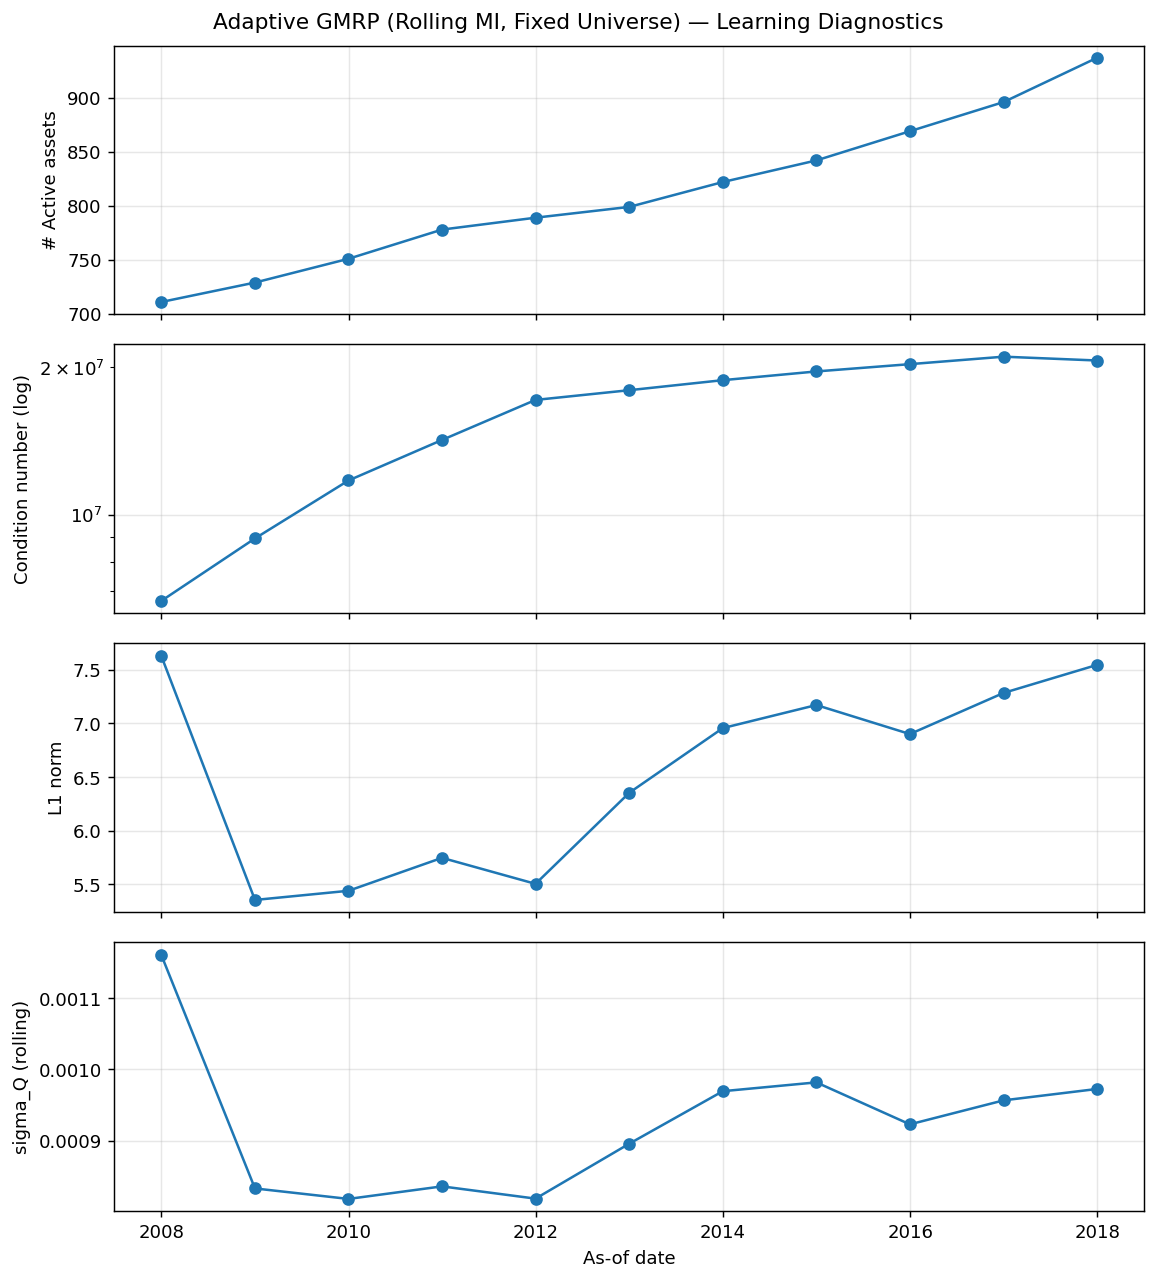

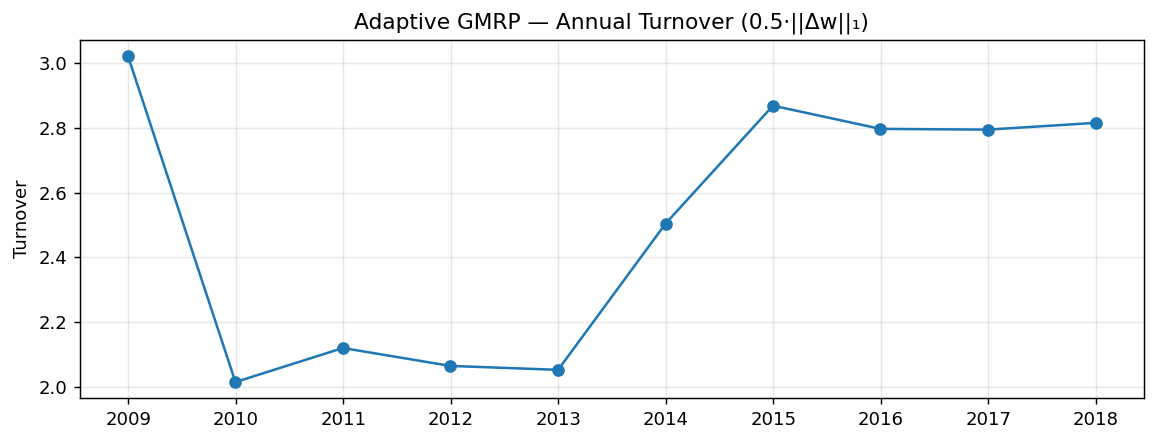

In [11]:
# Aggregate, save outputs, diagnostics

if not all_weights:
    print("No weights were calculated — nothing to save.")
else:
    # Stack per-date Series into a single wide table (index = as-of date, columns = label union).
    df_weights_online = pd.DataFrame(all_weights).T
    df_weights_online.index = pd.to_datetime(df_weights_online.index).normalize()
    df_weights_online.index.name = "asof_date"
    df_weights_online = df_weights_online.sort_index()

    start_tag = df_weights_online.index.min().strftime("%Y")
    end_tag   = df_weights_online.index.max().strftime("%Y")

    # Keep this filename stable so downstream notebooks/scripts don't break.
    OUT_WIDE = OUTPUT_DIR / f"gmrp_weights_online_expanding_wide_{start_tag}_to_{end_tag}.parquet"
    df_weights_online.to_parquet(OUT_WIDE)
    print(f"Saved WIDE weights → {OUT_WIDE} | shape={df_weights_online.shape}")

    # Metadata is useful for debugging: how many names survived filters, ridge size, conditioning, etc.
    if meta_rows:
        df_meta = pd.DataFrame(meta_rows).sort_values("asof_date")
        OUT_META = OUTPUT_DIR / f"online_gmrp_meta_{start_tag}_to_{end_tag}.parquet"
        df_meta.to_parquet(OUT_META)
        print(f"Saved META → {OUT_META} | rows={len(df_meta)}")
    else:
        df_meta = None

    # Turnover: 0.5 * ||Δw||_1 computed on the union axis (missing weights treated as 0).
    df_w = df_weights_online.fillna(0.0).sort_index()
    tovr = []
    prev = None
    for dt, row in df_w.iterrows():
        v = row.to_numpy(dtype=float)
        if prev is not None:
            tovr.append((dt, 0.5 * float(np.abs(v - prev).sum())))
        prev = v

    if tovr:
        df_turnover = pd.DataFrame(
            tovr,
            columns=["asof_date", "turnover"],
        ).set_index("asof_date")

        OUT_TURN = OUTPUT_DIR / f"online_gmrp_turnover_{start_tag}_to_{end_tag}.parquet"
        df_turnover.to_parquet(OUT_TURN)
        print(f"Saved TURNOVER → {OUT_TURN} | rows={len(df_turnover)}")
    else:
        df_turnover = None

    # Lightweight interactive preview (safe to skip in non-notebook runs).
    try:
        display(df_weights_online.iloc[:, :min(10, df_weights_online.shape[1])].head())
        if df_meta is not None:
            display(df_meta.tail(5))
        if df_turnover is not None:
            display(df_turnover.tail(5))
    except Exception:
        pass

# Quick diagnostic plots: how the kernel/solution behaved across as-of dates.
if 'df_meta' in locals() and df_meta is not None and not df_meta.empty:
    fig, ax = plt.subplots(4, 1, figsize=(9, 10), sharex=True)

    ax[0].plot(df_meta["asof_date"], df_meta["n_assets_after_isolated"], marker="o", lw=1.4)
    ax[0].set_ylabel("# Active assets")
    ax[0].grid(alpha=0.3)

    ax[1].plot(df_meta["asof_date"], df_meta["cond_est"], marker="o", lw=1.4)
    ax[1].set_yscale("log")
    ax[1].set_ylabel("Condition number (log)")
    ax[1].grid(alpha=0.3)

    ax[2].plot(df_meta["asof_date"], df_meta["L1_norm"], marker="o", lw=1.4)
    ax[2].set_ylabel("L1 norm")
    ax[2].grid(alpha=0.3)

    ax[3].plot(df_meta["asof_date"], df_meta["sigma_Q"], marker="o", lw=1.4)
    ax[3].set_ylabel("sigma_Q (rolling)")
    ax[3].set_xlabel("As-of date")
    ax[3].grid(alpha=0.3)

    fig.suptitle("Adaptive GMRP (Rolling MI, Fixed Universe) — Learning Diagnostics")
    fig.tight_layout()
    plt.show()

if 'df_turnover' in locals() and df_turnover is not None and not df_turnover.empty:
    plt.figure(figsize=(9, 3.5))
    plt.plot(df_turnover.index, df_turnover["turnover"], "-o", lw=1.4)
    plt.title("Adaptive GMRP — Annual Turnover (0.5⋅||Δw||₁)")
    plt.ylabel("Turnover")
    plt.grid(alpha=0.3)
    plt.tight_layout()
    plt.show()

In [17]:
# Extension: compute rolling GMRP weights through end of 2024

import numpy as np
import pandas as pd

# Extended sample period (post-2018 chunk).
EXT_START_TAG = "2018-06-30"
EXT_END_TAG   = "2024-12-30"

CORE_FILE_EXT = PROCESSED / f"crsp_weekly_core_{EXT_START_TAG}_to_{EXT_END_TAG}.parquet"
UNIV_FILE_EXT = PROCESSED / f"crsp_weekly_universe_{EXT_START_TAG}_to_{EXT_END_TAG}_top1000_liq20p_rebalance-monthly_W-FRI.parquet"

# Sanity check: fail fast if the extension artifacts aren't present.
if not CORE_FILE_EXT.exists():
    raise FileNotFoundError(f"Extended core file not found: {CORE_FILE_EXT}")
if not UNIV_FILE_EXT.exists():
    raise FileNotFoundError(f"Extended universe file not found: {UNIV_FILE_EXT}")

print(f"\n[EXTENSION] Using extended Core:     {CORE_FILE_EXT.name}")
print(f"[EXTENSION] Using extended Universe: {UNIV_FILE_EXT.name}")

# Load the extension chunk and append it to the baseline core to get a single continuous panel.
core_ext, univ_ext, RET_COL_EXT = load_full_data(CORE_FILE_EXT, UNIV_FILE_EXT)

# If the return column differs across files, stick with the extension’s column for the extension rows.
if RET_COL_EXT != RET_COL:
    print(
        f"[EXTENSION] Warning: RET_COL_EXT={RET_COL_EXT!r} != baseline RET_COL={RET_COL!r}. "
        f"Using {RET_COL_EXT!r} for the extension."
    )
    RET_COL_USE = RET_COL_EXT
else:
    RET_COL_USE = RET_COL

# Combine baseline + extension and dedupe on the natural key.
core_full_ext = pd.concat([core_full, core_ext], ignore_index=True)
core_full_ext = core_full_ext.drop_duplicates(subset=["date", "permno"]).sort_values("date").reset_index(drop=True)

max_data_date_ext = core_full_ext["date"].max()
print(f"[EXTENSION] Combined core span: {core_full_ext['date'].min().date()} → {max_data_date_ext.date()}")

# Static universe is still defined as-of 2018-06-29 (baseline definition).
# Recompute it from the extended universe as a check, but keep the baseline result as authoritative.
STATIC_ASOF = pd.Timestamp("2018-06-29")

static_permnos_ext, static_label_map_ext = get_asof_universe_and_labels(univ_ext, STATIC_ASOF)

if set(static_permnos_ext) != set(STATIC_PERMNOS):
    print(
        "[EXTENSION] WARNING: static PERMNO set from extended universe differs "
        "from baseline STATIC_PERMNOS; using baseline static universe."
    )

STATIC_PERMNOS_EXT   = STATIC_PERMNOS
STATIC_LABEL_MAP_EXT = STATIC_LABEL_MAP

print(
    f"[EXTENSION] Static universe size (as of {STATIC_ASOF.date()}): "
    f"{len(STATIC_PERMNOS_EXT)} names."
)

# Build the list of year-end as-of dates we want for the extension period.
YE_START = pd.Timestamp("2018-12-31")
YE_END   = pd.Timestamp("2024-12-31")
ext_rebalance_dates = pd.date_range(start=YE_START, end=YE_END, freq="YE")

# Pull the baseline wide weights (either from memory or from disk) and figure out what's missing.
if "df_weights_online" in globals():
    df_base = df_weights_online.copy()
    out_wide_path = OUT_WIDE
    print(f"[EXTENSION] Found in-memory df_weights_online with shape {df_base.shape}.")
else:
    wide_files = sorted(OUTPUT_DIR.glob("gmrp_weights_online_expanding_wide_*.parquet"))
    if not wide_files:
        raise FileNotFoundError("No existing wide online-weight file found in OUTPUT_DIR.")
    out_wide_path = wide_files[-1]
    df_base = pd.read_parquet(out_wide_path)
    df_base.index = pd.to_datetime(df_base.index).normalize()
    df_base.index.name = "asof_date"
    OUT_WIDE = out_wide_path
    print(f"[EXTENSION] Loaded baseline wide weights from {OUT_WIDE} with shape {df_base.shape}.")

already_have = set(df_base.index)
new_dates = [d.normalize() for d in ext_rebalance_dates if d.normalize() not in already_have]

print(f"[EXTENSION] Year-end dates to compute: {len(new_dates)}")
print("            ", [d.date() for d in new_dates])


[EXTENSION] Using extended Core:     crsp_weekly_core_2018-06-30_to_2024-12-30.parquet
[EXTENSION] Using extended Universe: crsp_weekly_universe_2018-06-30_to_2024-12-30_top1000_liq20p_rebalance-monthly_W-FRI.parquet
Loading data...
[EXTENSION] Combined core span: 1996-12-27 → 2024-12-27
[EXTENSION] WARNING: static PERMNO set from extended universe differs from baseline STATIC_PERMNOS; using baseline static universe.
[EXTENSION] Static universe size (as of 2018-06-29): 1000 names.
[EXTENSION] Found in-memory df_weights_online with shape (11, 937).
[EXTENSION] Year-end dates to compute: 7
             [datetime.date(2018, 12, 31), datetime.date(2019, 12, 31), datetime.date(2020, 12, 31), datetime.date(2021, 12, 31), datetime.date(2022, 12, 31), datetime.date(2023, 12, 31), datetime.date(2024, 12, 31)]


In [19]:
# Compute rolling GMRP on new year-end dates (2018–2024)

# Use the same rolling window length as the baseline run unless overridden.
ROLL_WIN_YEARS     = globals().get("ROLL_WIN_YEARS", 10)
STATIC_TRAIN_START = globals().get("STATIC_TRAIN_START", START_DATE)

ext_weights   = {}
ext_meta_rows = []

max_core_date_ext = core_full_ext["date"].max()
print(f"[EXTENSION] Extended core data max date: {max_core_date_ext.date()}")

for asof_date in new_dates:
    print("\n" + "="*72)
    print(f"[EXTENSION] As-of date: {asof_date.date()}")

    # Training window ends just before the as-of date when no-lookahead is enabled.
    # Also clamp to the max date available in the combined core.
    train_end_candidate = asof_date - pd.Timedelta(days=1) if NO_LOOKAHEAD_GUARD else asof_date
    train_end = min(train_end_candidate, max_core_date_ext)

    # Rolling start is trailing ROLL_WIN_YEARS, but never earlier than the configured start.
    train_start_candidate = train_end - pd.DateOffset(years=ROLL_WIN_YEARS)
    train_start = max(STATIC_TRAIN_START, train_start_candidate)

    print(f"  Training window: {train_start.date()} → {train_end.date()}")

    # Build wide log-return matrix on the fixed static universe.
    df_ret = build_wide_returns(
        core_full_ext,
        train_start,
        train_end,
        STATIC_PERMNOS_EXT,
        STATIC_LABEL_MAP_EXT,
        RET_COL_USE
    )
    if df_ret.empty:
        print("  Skipping: no returns in training window.")
        continue

    # Drop names with too little data before doing any pairwise MI work.
    keep_cols = df_ret.columns[df_ret.notna().sum() >= COVERAGE_FLOOR].tolist()
    if len(keep_cols) < 50:
        print(f"  Skipping: too few assets after coverage filter ({len(keep_cols)}).")
        continue
    df_ret_f = df_ret[keep_cols].copy()
    print(f"  Coverage-kept assets: {len(keep_cols)}")

    # Gaussian copula transform puts each marginal on ~N(0,1) while keeping rank structure.
    df_z = gaussian_copula_transform(df_ret_f)

    # Pairwise MI on maximal overlaps inside this rolling window.
    R_mi = compute_pairwise_mi(
        df_z,
        K_NEIGHBORS,
        MIN_OVERLAP,
        N_JOBS,
        BATCH_PAIRS
    )

    # Clean the MI matrix and drop names that are effectively isolated in MI space.
    Q_sanit = sanitize_kernel_mi(R_mi)
    active_mask = Q_sanit.sum(axis=1) > 1e-9
    Q_active = Q_sanit.loc[active_mask, active_mask].copy()
    n_removed = int((~active_mask).sum())
    if Q_active.shape[0] < 10:
        print("  Skipping: kernel collapsed after isolation drop.")
        continue
    if n_removed > 0:
        print(f"  Removed isolated assets: {n_removed}")

    # PSD projection + ridge so the kernel can be inverted stably.
    Q_psd = nearest_psd(Q_active.to_numpy(copy=True), eps_eig=0.0)
    ridge = choose_ridge(Q_psd, RIDGE_MIN_EIG, KAPPA_MAX)
    Q_reg = Q_psd + ridge * np.eye(Q_psd.shape[0])

    evals = eigvalsh(Q_reg)
    eig_min, eig_max = float(evals.min()), float(evals.max())
    cond_est = float(eig_max / max(eig_min, 1e-16))
    print(f"  Ridge={ridge:.1e} | eig_min={eig_min:.3e} | eig_max={eig_max:.3e} | cond≈{cond_est:.2e}")

    # Solve the unconstrained GMRP weights on the MI-active subset.
    b_active = solve_gmrp(Q_reg)
    weights_active = pd.Series(b_active, index=Q_active.index, name=asof_date)

    # Expand back to the full static label axis, filling missing names with 0 and renormalizing.
    all_labels = list(STATIC_LABEL_MAP_EXT.values())
    full_weights = pd.Series(0.0, index=all_labels, dtype=float, name=asof_date)
    full_weights.loc[weights_active.index] = weights_active.values
    full_weights /= full_weights.sum()

    L1_norm = float(np.abs(full_weights).sum())
    print(f"  Full-universe GMRP L1={L1_norm:.3f} | #nonzero={int((full_weights!=0).sum())}")

    # Save a per-date checkpoint so the extension can be resumed easily.
    perdate_path = CHECKPOINT_DIR / f"gmrp_weights_online_{asof_date.strftime('%Y%m%d')}.parquet"
    full_weights.to_frame("weight").to_parquet(perdate_path)
    print(f"  [saved] {perdate_path.name}")

    ext_weights[asof_date] = full_weights

    ext_meta_rows.append({
        "asof_date": asof_date,
        "train_start": train_start,
        "train_end": train_end,
        "universe_size_raw": int(len(STATIC_PERMNOS_EXT)),
        "n_assets_after_coverage": int(len(keep_cols)),
        "n_assets_after_isolated": int(Q_active.shape[0]),
        "ridge": float(ridge),
        "eig_min": float(eig_min),
        "eig_max": float(eig_max),
        "cond_est": float(cond_est),
        "L1_norm": float(L1_norm),
        "COVERAGE_FLOOR": int(COVERAGE_FLOOR),
        "MIN_OVERLAP": int(MIN_OVERLAP),
        "K_NEIGHBORS": int(K_NEIGHBORS),
    })

print("\n[EXTENSION] Finished rolling MI/GMRP for extension dates.")

[EXTENSION] Extended core data max date: 2024-12-27

[EXTENSION] As-of date: 2018-12-31
  Training window: 2008-12-30 → 2018-12-30
  Coverage-kept assets: 1000
  Estimating MI for 499,500 pairs using 13 jobs...


  MI estimation finished in 1,366.1s.
  Removed isolated assets: 35
  Ridge=1.0e-05 | eig_min=1.000e-05 | eig_max=1.939e+02 | cond≈1.94e+07
  Full-universe GMRP L1=7.551 | #nonzero=965
  [saved] gmrp_weights_online_20181231.parquet

[EXTENSION] As-of date: 2019-12-31
  Training window: 2009-12-30 → 2019-12-30
  Coverage-kept assets: 1000
  Estimating MI for 499,500 pairs using 13 jobs...


  MI estimation finished in 1,406.7s.
  Removed isolated assets: 15
  Ridge=1.0e-05 | eig_min=1.000e-05 | eig_max=1.772e+02 | cond≈1.77e+07
  Full-universe GMRP L1=7.551 | #nonzero=985
  [saved] gmrp_weights_online_20191231.parquet

[EXTENSION] As-of date: 2020-12-31
  Training window: 2010-12-30 → 2020-12-30
  Coverage-kept assets: 1000
  Estimating MI for 499,500 pairs using 13 jobs...


  MI estimation finished in 1,654.6s.
  Removed isolated assets: 7
  Ridge=1.0e-05 | eig_min=1.000e-05 | eig_max=2.131e+02 | cond≈2.13e+07
  Full-universe GMRP L1=7.029 | #nonzero=993
  [saved] gmrp_weights_online_20201231.parquet

[EXTENSION] As-of date: 2021-12-31
  Training window: 2011-12-30 → 2021-12-30
  Coverage-kept assets: 1000
  Estimating MI for 499,500 pairs using 13 jobs...


  MI estimation finished in 1,522.9s.
  Removed isolated assets: 7
  Ridge=1.0e-05 | eig_min=1.000e-05 | eig_max=1.859e+02 | cond≈1.86e+07
  Full-universe GMRP L1=7.297 | #nonzero=993
  [saved] gmrp_weights_online_20211231.parquet

[EXTENSION] As-of date: 2022-12-31
  Training window: 2012-12-30 → 2022-12-30
  Coverage-kept assets: 1000
  Estimating MI for 499,500 pairs using 13 jobs...


  MI estimation finished in 1,541.3s.
  Removed isolated assets: 7
  Ridge=1.0e-05 | eig_min=1.000e-05 | eig_max=2.006e+02 | cond≈2.01e+07
  Full-universe GMRP L1=7.070 | #nonzero=993
  [saved] gmrp_weights_online_20221231.parquet

[EXTENSION] As-of date: 2023-12-31
  Training window: 2013-12-30 → 2023-12-30
  Coverage-kept assets: 1000
  Estimating MI for 499,500 pairs using 13 jobs...


  MI estimation finished in 1,461.6s.
  Removed isolated assets: 7
  Ridge=1.0e-05 | eig_min=1.000e-05 | eig_max=2.006e+02 | cond≈2.01e+07
  Full-universe GMRP L1=7.284 | #nonzero=993
  [saved] gmrp_weights_online_20231231.parquet

[EXTENSION] As-of date: 2024-12-31
  Training window: 2014-12-27 → 2024-12-27
  Coverage-kept assets: 1000
  Estimating MI for 499,500 pairs using 13 jobs...


  MI estimation finished in 1,540.7s.
  Removed isolated assets: 7
  Ridge=1.0e-05 | eig_min=1.000e-05 | eig_max=1.951e+02 | cond≈1.95e+07
  Full-universe GMRP L1=7.391 | #nonzero=993
  [saved] gmrp_weights_online_20241231.parquet

[EXTENSION] Finished rolling MI/GMRP for extension dates.


In [20]:
# Append extension weights to wide / meta / turnover files

if not ext_weights:
    print("[EXTENSION] No new dates processed; nothing to update.")
else:
    # Stack the new per-date Series into a wide table (same format as the baseline output).
    df_new = pd.DataFrame(ext_weights).T
    df_new.index = pd.to_datetime(df_new.index).normalize()
    df_new.index.name = "asof_date"
    df_new = df_new.sort_index()

    # Align on the union of columns and treat missing weights as 0 for consistent arithmetic.
    all_cols = sorted(set(df_base.columns) | set(df_new.columns))
    df_base_aligned = df_base.reindex(columns=all_cols).fillna(0.0)
    df_new_aligned  = df_new.reindex(columns=all_cols).fillna(0.0)

    df_combined = pd.concat([df_base_aligned, df_new_aligned], axis=0).sort_index()

    # Write back to the same wide file path used by the baseline run unless overridden.
    if "OUT_WIDE" not in globals():
        wide_files = sorted(OUTPUT_DIR.glob("gmrp_weights_online_expanding_wide_*.parquet"))
        OUT_WIDE = wide_files[-1] if wide_files else (OUTPUT_DIR / "gmrp_weights_online_expanding_wide_extended.parquet")

    df_combined.to_parquet(OUT_WIDE)
    df_weights_online = df_combined

    print(f"[EXTENSION] Updated WIDE weights → {OUT_WIDE}")
    print(f"            New shape: {df_weights_online.shape}")

    # Merge metadata the same way: append new rows and sort by asof_date.
    if "df_meta" in globals():
        df_meta_base = df_meta.copy()
    else:
        meta_files = sorted(OUTPUT_DIR.glob("online_gmrp_meta_*.parquet"))
        df_meta_base = pd.read_parquet(meta_files[-1]) if meta_files else pd.DataFrame()

    if ext_meta_rows:
        df_meta_new = pd.DataFrame(ext_meta_rows)
        df_meta_combined = pd.concat([df_meta_base, df_meta_new], ignore_index=True)
    else:
        df_meta_combined = df_meta_base

    df_meta_combined = df_meta_combined.sort_values("asof_date")

    if "OUT_META" not in globals():
        meta_files = sorted(OUTPUT_DIR.glob("online_gmrp_meta_*.parquet"))
        OUT_META = meta_files[-1] if meta_files else (OUTPUT_DIR / "online_gmrp_meta_extended.parquet")

    df_meta_combined.to_parquet(OUT_META)
    df_meta = df_meta_combined

    print(f"[EXTENSION] Updated META → {OUT_META} | rows={len(df_meta)}")

    # Turnover is computed on the full extended grid with missing weights treated as 0.
    df_w_for_turn = df_weights_online.fillna(0.0).sort_index()

    tovr = []
    prev = None
    for dt, row in df_w_for_turn.iterrows():
        v = row.to_numpy(dtype=float)
        if prev is not None:
            tovr.append((dt, 0.5 * float(np.abs(v - prev).sum())))
        prev = v

    if tovr:
        df_turnover = pd.DataFrame(tovr, columns=["asof_date", "turnover"]).set_index("asof_date")

        if "OUT_TURN" not in globals():
            turn_files = sorted(OUTPUT_DIR.glob("online_gmrp_turnover_*.parquet"))
            OUT_TURN = turn_files[-1] if turn_files else (OUTPUT_DIR / "online_gmrp_turnover_extended.parquet")

        df_turnover.to_parquet(OUT_TURN)
        print(f"[EXTENSION] Updated TURNOVER → {OUT_TURN} | rows={len(df_turnover)}")

    # Quick interactive preview (safe to skip outside notebooks).
    try:
        display(df_weights_online.tail(3))
        display(df_meta.tail(3))
        display(df_turnover.tail(3))
    except Exception:
        pass

[EXTENSION] Updated WIDE weights → C:\Users\bseis\ABthesis\data\analysis\online_gmrp\gmrp_weights_online_expanding_wide_2007_to_2017.parquet
            New shape: (18, 1000)
[EXTENSION] Updated META → C:\Users\bseis\ABthesis\data\analysis\online_gmrp\online_gmrp_meta_2007_to_2017.parquet | rows=18
[EXTENSION] Updated TURNOVER → C:\Users\bseis\ABthesis\data\analysis\online_gmrp\online_gmrp_turnover_2007_to_2017.parquet | rows=17


,PERMNO_10104,PERMNO_10107,PERMNO_10138,PERMNO_10145,PERMNO_10182,PERMNO_10220,PERMNO_10302,PERMNO_10375,PERMNO_10397,PERMNO_10516,PERMNO_10517,PERMNO_10629,PERMNO_10693,PERMNO_10696,PERMNO_10777,PERMNO_10874,PERMNO_10909,PERMNO_10932,PERMNO_10933,PERMNO_11308,PERMNO_11369,PERMNO_11403,PERMNO_11404,PERMNO_11533,PERMNO_11552,PERMNO_11600,PERMNO_11618,PERMNO_11636,PERMNO_11664,PERMNO_11674,PERMNO_11752,PERMNO_11786,PERMNO_11809,PERMNO_11850,PERMNO_11891,PERMNO_11896,PERMNO_11955,PERMNO_11992,PERMNO_12008,PERMNO_12036,...,PERMNO_92257,PERMNO_92293,PERMNO_92296,PERMNO_92322,PERMNO_92326,PERMNO_92402,PERMNO_92502,PERMNO_92570,PERMNO_92602,PERMNO_92611,PERMNO_92614,PERMNO_92618,PERMNO_92648,PERMNO_92655,PERMNO_92729,PERMNO_92772,PERMNO_92775,PERMNO_92778,PERMNO_92852,PERMNO_92940,PERMNO_92984,PERMNO_93089,PERMNO_93096,PERMNO_93098,PERMNO_93101,PERMNO_93132,PERMNO_93150,PERMNO_93174,PERMNO_93179,PERMNO_93246,PERMNO_93264,PERMNO_93295,PERMNO_93312,PERMNO_93330,PERMNO_93374,PERMNO_93420,PERMNO_93422,PERMNO_93423,PERMNO_93429,PERMNO_93436
asof_date,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
2022-12-31,0.003002,0.005711,-0.020246,-0.011339,0.010008,0.016328,0.007177,0.017640,-0.015377,0.003819,0.010137,-0.003581,0.007215,-0.014003,-0.000252,-0.003491,-0.020505,0.000980,-0.009840,-0.006429,-0.003855,0.006711,0.004486,-0.000104,-0.009789,-0.009305,0.001605,-0.005340,0.010490,0.000924,0.014525,-0.000889,0.000675,0.012004,-0.001337,0.014670,0.002534,-0.009075,-0.002401,0.001721,...,0.004199,0.011990,0.005346,0.003050,0.003698,0.002223,-0.004418,-0.016172,0.000801,-0.003920,0.006046,0.005421,0.000631,-0.018993,0.001190,0.018548,0.007545,-0.001855,0.004115,-0.015454,0.007474,-0.006132,0.000452,-0.002248,0.000197,0.005582,-0.010913,0.005211,0.011737,-0.003612,0.010207,0.017362,-0.014045,0.000619,-0.005266,0.006838,0.014467,-0.003506,0.003681,-0.003871
2023-12-31,0.010163,0.005180,-0.018855,-0.011195,0.007982,0.018746,0.008782,0.025291,-0.015135,0.003402,0.006416,-0.003286,0.005349,-0.016064,0.004307,-0.011681,-0.016249,-0.002128,-0.011907,-0.003639,-0.008496,0.000493,0.004492,0.005378,-0.006845,-0.012509,-0.005346,-0.002050,-0.000567,-0.000085,0.001735,0.002254,0.005450,0.001963,-0.005887,0.006281,0.002511,-0.005318,0.010452,-0.009139,...,0.010953,0.004926,0.008626,0.003657,0.002361,0.004282,-0.016270,-0.007247,0.002129,0.000113,0.003103,0.004904,0.000313,-0.018824,-0.007594,0.015164,0.003980,0.001438,0.005077,-0.022625,0.008086,-0.001385,-0.001913,-0.003143,-0.002336,0.012373,-0.011493,-0.003934,0.005857,-0.007727,0.015379,0.013631,-0.010082,0.010864,-0.008471,0.002318,0.014104,-0.001722,0.002950,-0.007838
2024-12-31,0.012343,0.009321,-0.003259,-0.010367,-0.001833,0.021690,0.007748,0.025766,-0.007610,0.003299,0.007979,0.001075,-0.002730,-0.012198,0.003398,-0.010562,-0.012436,-0.006652,-0.005262,-0.011499,-0.003105,0.004978,-0.000355,0.005704,-0.007773,-0.004265,0.000628,0.001715,0.002050,-0.001787,-0.006038,-0.004902,0.001249,0.004221,-0.001109,0.000932,-0.002048,-0.016551,0.007585,-0.003748,...,-0.004991,-0.001153,0.010882,0.006555,0.006146,-0.009557,-0.004254,-0.007559,0.009659,-0.001408,0.003706,0.011160,-0.008623,-0.012087,-0.005702,0.013276,-0.001598,-0.006504,0.000693,-0.018501,0.018833,-0.009718,-0.004127,-0.003986,-0.007682,0.010923,-0.017826,-0.008443,0.007130,0.011354,-0.002667,0.015857,-0.015711,0.008791,0.001364,0.004762,0.014098,0.000470,0.011002,0.001772


,asof_date,train_start,train_end,universe_size_raw,n_assets_after_coverage,n_assets_after_isolated,ridge,eig_min,eig_max,cond_est,L1_norm,sigma_Q,COVERAGE_FLOOR,MIN_OVERLAP,K_NEIGHBORS,ROLL_WIN_YEARS
15,2022-12-31,2012-12-30,2022-12-30,1000,1000,993,0.00001,0.00001,200.571162,2.005712e+07,7.069801,NaN,52,156,6,NaN
16,2023-12-31,2013-12-30,2023-12-30,1000,1000,993,0.00001,0.00001,200.574162,2.005742e+07,7.284490,NaN,52,156,6,NaN
17,2024-12-31,2014-12-27,2024-12-27,1000,1000,993,0.00001,0.00001,195.081513,1.950815e+07,7.390786,NaN,52,156,6,NaN


,turnover
asof_date,
2022-12-31,2.335338
2023-12-31,2.073552
2024-12-31,2.422995
